# Part 1: midi2vec

This notebook reproduces the [midi2vec paper](http://www.semantic-web-journal.net/content/midi2vec-learning-midi-embeddings-reliable-prediction-symbolic-music-metadata-0) from scratch. We will use a small dataset, namely, a part of [Ben Burgraff's MIDI collection](https://cariart.tripod.com/MIDIS-2.html). 

MIDI2vec actually goes in two steps:

1. We build a graph with MIDI files
2. We run node2vec on the graph.


In [1]:
import networkx as nx
import seaborn as sns
import pretty_midi
import numpy as np
import glob

## Step 1: build a graph with MIDI miles

The midi data is transformed into a graph where two MIDI files are connected if they share the same instruments, tempo, time signature, and notes characteristic (for note characteristics, MIDI2graph connects MIDI files with the same average pitch, velocity and duration for notes that start around the same time). The function below, `get_graph` implements this procedure as described in the paper.

In [18]:
def get_graph(number_nodes, number_noteg=99999):
    g = nx.Graph()
    song_names = []
    idx = 0
    for x in glob.glob("./data/*"):
        if idx > number_nodes:
            break
        idx += 1
        song_name = x.split("/")[-1][:-4]
        song_names.append("SONG:" + song_name)
        try:
            midi_data = pretty_midi.PrettyMIDI('./data/{}.mid'.format(song_name))
            midi_data.time_signature_changes[0]
        except:
            continue
        # This creates a dictionary that groups notes that happened in the same 10th of a second
        duration = int(midi_data.get_end_time() * 100)
        tmp_dict1 = dict()
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                start = int(note.start * 100)
                if start not in tmp_dict1:
                    tmp_dict1[start] = {"pitch": [], "duration": [], "velocity": []}
                tmp_dict1[start]["pitch"].append(str(note.pitch))
                tmp_dict1[start]["duration"].append(float(note.duration))
                tmp_dict1[start]["velocity"].append(float(note.velocity))

        # Creates song node
        g.add_node("SONG:" + song_name)

        # This creates a (potential) node for each 10th of a second. Each node is uniquely characterized by:
        # 1 - all the pitches of notes starting in that second
        # 2 - the max duration of a note starting in that second
        # 3 - the mean velocity of the notes starting in that second
        idx = 0
        for start, tmp in tmp_dict1.items():
            pitchsignature = "-".join(tmp_dict1[start]["pitch"])
            maxduration = str(int(max(tmp_dict1[start]["duration"]) * 100))
            meanvelocity = str(int(np.mean(tmp_dict1[start]["velocity"]) * 100))
            note_group = "NOTEG:" + pitchsignature + "|" + maxduration + "|" + meanvelocity
            g.add_node(note_group)
            g.add_edge("SONG:" + song_name, note_group)
            idx += 1
            if idx > number_noteg:
                break


        # Creates nodes associated with instruments
        for instrument in midi_data.instruments:
            g.add_node("INSTRUMENT:" + str(instrument.program))
            g.add_edge("INSTRUMENT:" + str(instrument.program), "SONG:" + song_name)

        # Creates nodes associated with time signature
        timesignature = "TIMESIG:{}/{}".format(midi_data.time_signature_changes[0].numerator,
                                       midi_data.time_signature_changes[0].denominator)
        g.add_edge("SONG:" + song_name, timesignature)

        # Creates nodes associated with tempo
        g.add_edge("SONG:" + song_name, "TEMPO:" + str(midi_data.estimate_tempo() // 10))
    return g, song_names


Although the dataset is small, it still generates a large graph. Nonetheless, we can simply use the parameter `number_nodes` in the `get_graph` function to generate a graph with just 5 midi files. This one can be easily visualized, as we do below. Note that we look at the 2-core of the graph for simplicity sake, i.e., we only consider the nodes that have degree atleast 2.

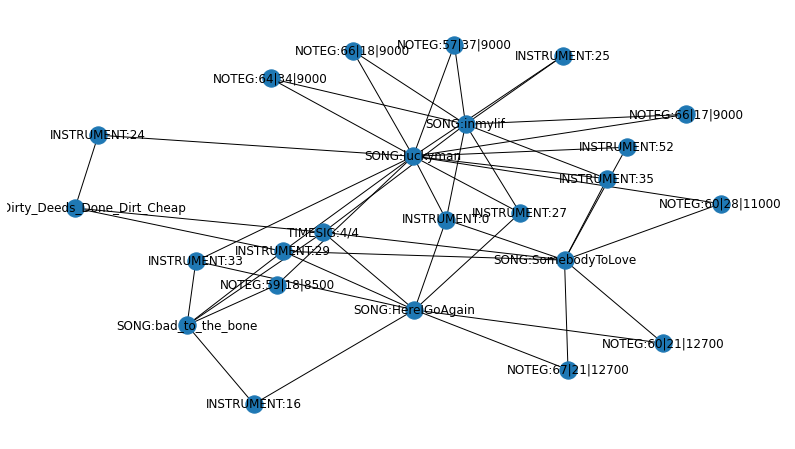

In [7]:
from networkx.algorithms import k_core
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(14,8))
g, song_names = get_graph(5)
g = k_core(g, k=2)

nx.draw(g,  with_labels = True)

Note that the the different songs, nodes prefixed by the string `SONG:` are connected to:
1. different instruments, nodes prefixed by the string `INSTRUMENT:`;
2. time signatures, the nodes (only one, really) prefixed by `TIMESIG:";
2. the tempo (not shown in this graph) divided by 10, prefixed by `TEMPO:";
3. and note groups, the nodes prefixed by `NOTEG:`;


Each note group is characterized by three different numbers, e.g., `NOTEG:60|21|12700`. These numbers represent:
1. The pitch of the note (e.g., 60);
2. The max duration of the note times 100 (e.g., 21);
3. The mean velocity of the note times 100 (e.g., 12700).

Here it so happens that notes only share note groups containing single notes, but if two notes are played in the same 10th of a second, the pitch is represented by a tuple. This can be seen in the graph below where we plot the first 4 note groups nodes for 1 specific song (SomebodyToLove). We can see for instance that there is a node `NOTEG:46-72|26|9550`. This note group represents two notes being played close to each other, with pitches 46 and 72! We can also see the `TEMPO:` node in the graph!

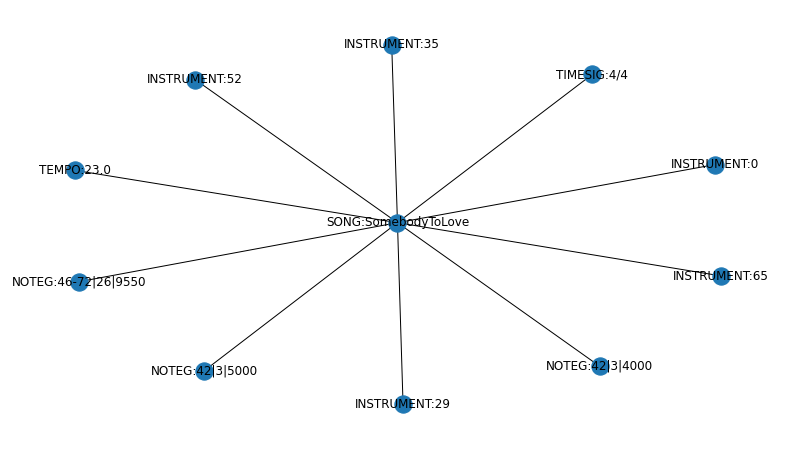

In [19]:
g, song_names = get_graph(1, 4)
fig, axs = plt.subplots(1, 1, figsize=(14,8))

nx.draw(g,  with_labels = True)

## Step 2: run node2vec

After the midi graph has been created, we run node2vec in this graph to obtain latent representations of each song.
`node2vec` (well explained [here](https://towardsdatascience.com/node2vec-explained-db86a319e9ab), [original paper](https://arxiv.org/pdf/1607.00653.pdf)). But the intuition of the algorithm (which we did not implement from scratch) is that:

### Generate random waks
We generate random walks thorugh the graph. These random walks are quite specific in the probability assigned to each node such that they can interpolate a Depth-First-Search behavior and a Breadth-First-Search behavior. For instance, we could generate a random walk:

- `SONG:X`, `INSTRUMENT:1`, `SONG:Y`, `TIMESIG:4/4`, `SONG:Z` ...

### Skip-gram

We use these random walks as inputs to skip-gram neural network architecture (see [the original paper](https://arxiv.org/pdf/1301.3781.pdf)). In other word, we create consider a window (e.g., of size 5) centered around a "target" node. In the random walk above, for instance, we can have:
- Target node: `SONG:Y`
- Context nodes: `SONG:X`, `INSTRUMENT:1`, `TIMESIG:4/4`, `SONG:Z`
    
The skip-gram model, creates all combinations between target and context notes:
- (`SONG:Y`, `SONG:X`)
- (`SONG:Y`, `SONG:Z`)
- (`SONG:Y`, `INSTRUMENT:1`)
- (`SONG:Y`, `TIMESIG:4/4`)

Then it feeds these tuples into a neural network where:
- The input is a vector of size N (the number of nodes in the graph).
- There is one hidden layer of size K
- The output layer is again of size N.

This neural network is trained with the tuples above using the context word to predict the target word. We do this over and over again and then obtain the weights associated with each word in the hidden layer, which is our embedding of size K!

In [20]:
from nodevectors import Node2Vec
g, song_names = get_graph(500, 10)
g = k_core(g, k=2)

In [21]:
from nodevectors import Node2Vec
g, song_names = get_graph(500, 10)
g = k_core(g, k=2)

# Fit embedding model to graph
g2v =  Node2Vec(
        walklen=10,
        epochs=40,
        n_components=128,
        return_weight=1,
        neighbor_weight=1,
        threads=0,
        w2vparams={
            'window': 5,
            'iter': 10,
            'batch_words': 128,
            'min_count': 0,
            'negative': 25,
            'sg': 1
        },
        verbose=True
    )
g2v.fit(g)

/Users/horta/opt/anaconda3/envs/py38/lib/python3.8/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


Making walks... Done, T=2.46
Mapping Walk Names... Done, T=0.05
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=2.87


## Visualizing our embedding

Finally, we can visualize our node embeddings. Our embeddings encode each song in 128 dimensions, but we use PCA to reduce this number to two dimensions! Note below that we already see some interesting patterns, even with this very small dataset!

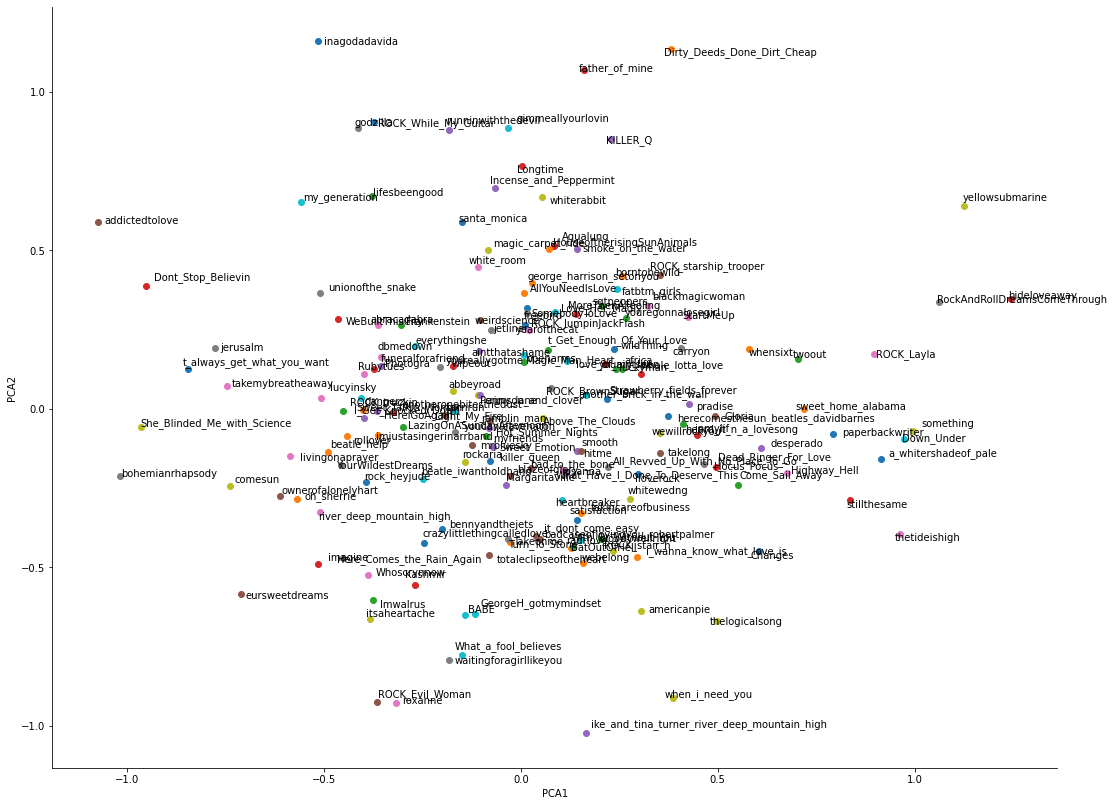

In [25]:
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
g2v.save_vectors("./test.v")
model = KeyedVectors.load_word2vec_format("./test.v")
X = np.stack([model[s] for s in song_names if s in model])
labels = [s for s in song_names if s in model]
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)

fig, axs = plt.subplots(1, 1, figsize=(18,14))
np.random.seed(1)
for idx, x in enumerate(X_t):
    label = labels[idx]
    if np.random.random() < 1:
        plt.text(x[0] + (np.random.random() - 0.5)/20, 
                 x[1] + (np.random.random() - 0.5)/20, 
                 label.replace("SONG:", ""))
    plt.scatter([x[0]], [x[1]])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
sns.despine()